| ![wired](https://www.sci.utah.edu/~pascucci/public/wired-logo-small.png)  | [WIRED Global Center](https://resilience.utah.edu/) + [National Science Data Fabric](https://nationalsciencedatafabric.org/) [Jupyter notebook](https://jupyter.org/) <br> created by [Arleth Z. Salinas](https://arlethzuri.github.io/), and [Valerio Pascucci](http://cedmav.com/)   |![nsdf](https://www.sci.utah.edu/~pascucci/public/NSDF-smaller.PNG)  |
|:---|:---:|---:|


###  WIRED Global Center  + National Science Data Fabric collaboration: Jupyter Notebook using 3 years of smoke forecast data over US and Canada stored in the cloud and dsitributed via regular internet connection.
Data source: [BlueSky Canada Smoke Forecast](https://bluesky4.eos.ubc.ca/)

## This notebook provide the instructions on how to read UBC firesmoke data from [`firsmoke_metadata.nc`](https://github.com/sci-visus/NSDF-WIRED/raw/main/data/firesmoke_metadata.nc) using xarray and the OpenVisus xarray backend.

Dashboard visible here: http://chpc3.nationalsciencedatafabric.org:9988/dashboards

## **Step 1: Importing the libraries**
### Please be sure to have libraries installed

In [1]:
# for numerical work
import numpy as np

# for accessing file system
import os

# for loading netcdf files, for metadata
import xarray as xr
# for connecting OpenVisus framework to xarray
# from https://github.com/sci-visus/openvisuspy, 
from openvisuspy.xarray_backend import OpenVisusBackendEntrypoint

# Used for processing netCDF time data
import time
import datetime
import requests
# Used for indexing via metadata
import pandas as pd

# for plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


#Stores the OpenVisus cache in the local direcrtory 
import os
os.environ["VISUS_CACHE"]="./visus_cache_can_be_erased"
os.environ['CURL_CA_BUNDLE'] = ''

## **Step 2: Reading the data & metadata from file**
### In this section, we load our data using `xr.open_dataset`.

In [2]:
# path to tiny NetCDF
url = 'https://github.com/sci-visus/NSDF-WIRED/raw/main/data/firesmoke_metadata.nc'

# Download the file using requests
response = requests.get(url)
local_netcdf = 'firesmoke_metadata.nc'
with open(local_netcdf, 'wb') as f:
    f.write(response.content)
    
# open tiny netcdf with xarray and OpenVisus backend
ds = xr.open_dataset(local_netcdf, engine=OpenVisusBackendEntrypoint)

ov.LoadDataset(http://atlantis.sci.utah.edu/mod_visus?dataset=UBC_fire_smoke_BSC&cached=1)
PM25
Adding field  PM25 shape  [27357, 381, 1081, 21] dtype  float32 labels  ['time', 'ROW', 'COL', 'resolution'] Max Resolution  20


In [3]:
ds

<xarray.Dataset>
Dimensions:            (time: 27357, ROW: 381, COL: 1081, resolution: 21,
                        VAR: 1, DATE-TIME: 2)
Dimensions without coordinates: time, ROW, COL, resolution, VAR, DATE-TIME
Data variables:
    PM25               (time, ROW, COL, resolution) float32 ...
    TFLAG              (time, VAR, DATE-TIME) int32 ...
    wrf_arw_init_time  (time, VAR, DATE-TIME) int32 ...
    resampled          (time) bool ...
    CDATE              (time) int32 ...
    CTIME              (time) int32 ...
    WDATE              (time) int32 ...
    WTIME              (time) int32 ...
    SDATE              (time) int32 ...
    STIME              (time) int32 ...
Attributes: (12/28)
    IOAPI_VERSION:  $Id: @(#) ioapi library version 3.0 $                    ...
    EXEC_ID:        ????????????????                                         ...
    FTYPE:          1
    TSTEP:          10000
    NTHIK:          1
    NCOLS:          1081
    ...             ...
    GDNAM:          HYSPLIT CONC    
    UPNAM:          hysplit2netCDF  
    VAR-LIST:       PM25            
    FILEDESC:       Hysplit Concentration Model Output                       ...
    HISTORY:        
    idx_url:        http://atlantis.sci.utah.edu/mod_visus?dataset=UBC_fire_s...

#### Data Variables Description
| Attribute         | Description                                                                                                           |
|-------------------|-----------------------------------------------------------------------------------------------------------------------|
| PM25              | The concentration of particulate matter (PM2.5) for each time step, layer, row, and column in the spatial grid.       |
| TFLAG             | The date and time of each data point.                                                                                 |
| wrf_arw_init_time | The time at which this prediction's weather forecast was initiated.                                                   |
| resampled         | Whether this timestamp was resampled from a 381x1041 to 381x1081 grid or not.                                         |
| CDATE             | The creation date of the data point, in YYYYDDD format.                                                                  |
| CTIME             | The creation time of the data point, in HHMMSS format.                                                                   |
| WDATE             | The date for which the weather forecast is initiated, in YYYYDDD format.                                              |
| WTIME             | The time for which the weather forecast is initiated, in HHMMSS format.                                               |
| SDATE             | The date for which the smoke forecast is initiated, in YYYYDDD format.                                                |
| STIME             | The time for which the weather forecast is initiated, in HHMMSS format.                                               |

## **Step 2.5, Calculate derived metadata using original metadata above to create coordinates**
### This is required to allow for indexing of data via metadata

#### Calculate latitude and longitude grid

In [4]:
# Get metadata to compute lon and lat
xorig = ds.XORIG
yorig = ds.YORIG
xcell = ds.XCELL
ycell = ds.YCELL
ncols = ds.NCOLS
nrows = ds.NROWS

longitude = np.linspace(xorig, xorig + xcell * (ncols - 1), ncols)
latitude = np.linspace(yorig, yorig + ycell * (nrows - 1), nrows)

print("Size of longitude & latitude arrays:")
print(f'np.size(longitude) = {np.size(longitude)}')
print(f'np.size(latitude) = {np.size(latitude)}\n')
print("Min & Max of longitude and latitude arrays:")
print(f'longitude: min = {np.min(longitude)}, max = {np.max(longitude)}')
print(f'latitude: min = {np.min(latitude)}, max = {np.max(latitude)}')

Size of longitude & latitude arrays:
np.size(longitude) = 1081
np.size(latitude) = 381

Min & Max of longitude and latitude arrays:
longitude: min = -160.0, max = -51.99999839067459
latitude: min = 32.0, max = 70.00000056624413


#### Using calculated latitude and longitude, create coordinates allowing for indexing data using lat/lon

In [5]:
# Create coordinates for lat and lon (credit: Aashish Panta)
ds.coords['lat'] = ('ROW', latitude)
ds.coords['lon'] = ('COL', longitude)

# Replace col and row dimensions with newly calculated lon and lat arrays (credit: Aashish Panta)
ds = ds.swap_dims({'COL': 'lon', 'ROW': 'lat'})

#### Create coordinates allowing for indexing data using timestamp

##### First, convert tflags to timestamps that are compatible with xarray

In [6]:
def parse_tflag(tflag):
    """
    Return the tflag as a datetime object
    :param list tflag: a list of two int32, the 1st representing date and 2nd representing time
    """
    # obtain year and day of year from tflag[0] (date)
    date = int(tflag[0])
    year = date // 1000 # first 4 digits of tflag[0]
    day_of_year = date % 1000 # last 3 digits of tflag[0]

    # create datetime object representing date
    final_date = datetime.datetime(year, 1, 1) + datetime.timedelta(days=day_of_year - 1)

    # obtain hour, mins, and secs from tflag[1] (time)
    time = int(tflag[1])
    hours = time // 10000 # first 2 digits of tflag[1]
    minutes = (time % 10000) // 100 # 3rd and 4th digits of tflag[1] 
    seconds = time % 100  # last 2 digits of tflag[1]

    # create final datetime object
    full_datetime = datetime.datetime(year, final_date.month, final_date.day, hours, minutes, seconds)
    return full_datetime

##### Return an array of the tflags as pandas timestamps

In [7]:
# get all tflags
tflag_values = ds['TFLAG'].values

# to store pandas timestamps
timestamps = []

# convert all tflags to pandas timestamps, store in timestamps list
for tflag in tflag_values:
    timestamps.append(pd.Timestamp(parse_tflag(tflag[0])))

# check out the first 3 timestamps
timestamps[0:3]

[Timestamp('2021-03-04 00:00:00'),
 Timestamp('2021-03-04 01:00:00'),
 Timestamp('2021-03-04 02:00:00')]

In [8]:
# set coordinates to each timestep with these pandas timestamps
ds.coords['time'] = ('time', timestamps)

#### The timestamps may not be intuitive. The following utility function returns the desired pandas timestamp based on your date and time of interest. 

##### When you index the data at a desired time, use this function to get the timestamp you need to index.

In [9]:
def get_timestamp(year, month, day, hour):
    """
    return a pandas timestamp using the given date-time arguments
    :param int year: year
    :param int month: month
    :param int day: day
    :param int hour: hour
    """
    # Convert year, month, day, and hour to a datetime object
    full_datetime = datetime.datetime(year, month, day, hour)
    
    # Extract components from the datetime object
    year = full_datetime.year
    day_of_year = full_datetime.timetuple().tm_yday
    hours = full_datetime.hour
    minutes = full_datetime.minute
    seconds = full_datetime.second

    # Compute tflag[0] and tflag[1]
    tflag0 = year * 1000 + day_of_year
    tflag1 = hours * 10000 + minutes * 100 + seconds

    # Return the Pandas Timestamp object
    return pd.Timestamp(full_datetime)

## **Step 3:  Select a `data_slice`**
### This section shows you how to load the data you want. 

#### You can index the data using indices, timestamps*, latitude & longitude, and by desired resolution**.
*Not setting any time means the first timestep available is selected.
**Not setting quality means full data resolution is selected.

---

##### In this case, let's get all available firesmoke data for March 5, 2021 00:00:00 and the time and date for which it's weather and smoke forecast were initiated.

In [10]:
# select timestamp
my_timestamp = get_timestamp(2021, 3, 5, 0)

# select resolution, let's use full resolution since data isn't too big at one time slice
# data resolution can be -19 for lowest res and 0 for highest res
data_resolution = 0

# get PM25 values and provide 4 values, the colons mean select all lat and lon indices
data_array_at_time = ds['PM25'].loc[my_timestamp, :, :, data_resolution]

# the metadata specifying weather and smoke forecast initialization times
resampled = ds['resampled'].loc[my_timestamp]
sdate = ds['SDATE'].loc[my_timestamp]
stime = ds['STIME'].loc[my_timestamp]
wdate = ds['WDATE'].loc[my_timestamp]
wtime = ds['WTIME'].loc[my_timestamp]

# notice, to access the data, you must append ".values" to the data array we got above
print(f'timestamp: {my_timestamp}')
print(f'resampled: {resampled.values} (boolean)')
print(f'SDATE is {sdate.values} (YYYYDDD)')
print(f'STIME is {stime.values} (HHMMSS)')
print(f'WDATE is {wdate.values} (YYYYDDD)')
print(f'WTIME is {wtime.values} (HHMMSS)')
print(f'shape of data_array_at_time.values = {np.shape(data_array_at_time.values)}')

timestamp: 2021-03-05 00:00:00
resampled: True (boolean)
SDATE is 2021063 (YYYYDDD)
STIME is 210000 (HHMMSS)
WDATE is 2021063 (YYYYDDD)
WTIME is 204413 (HHMMSS)
Using Max Resolution:  20
Time: 24, max_resolution: 20, logic_box=(0, 1081, 0, 381), field: PM25
shape of data_array_at_time.values = (381, 1081)


##### Perhaps we want to slice a specific latitude longitude range from our `data_array_at_time`, for example, latitude range `[35, 50]` and longitude range `[-140, -80]`. Let's do that below.

In [11]:
# # define range for latitude and longitude to use
min_lat = 35
max_lat = 50
min_lon = -140
max_lon = -80

# get PM25 values and provide 4 values, but this time at our desired ranges
data_array_at_latlon = ds['PM25'].loc[my_timestamp, min_lat:max_lat, min_lon:max_lon, data_resolution]

# notice, to access the data, you must append ".values" to the data array we got above
print(f'timestamp: {my_timestamp}')
print(f'shape of data_array_at_time.values = {np.shape(data_array_at_latlon.values)}')

timestamp: 2021-03-05 00:00:00
Using Max Resolution:  20
Time: 24, max_resolution: 20, logic_box=(200, 800, 30, 180), field: PM25
shape of data_array_at_time.values = (150, 600)


We show how to obtain this attribute information for a time step of one's choice, let's use 

#### The following are the max and min timestamps, lon/lat values, and data resolutions you can index by
##### Be sure you index within the data range, otherwise you may get errors since no data exists outside these ranges!

In [12]:
# NOTE: there is one dummy date, ignore ds['time'].values[-1]
print(f"earliest valid timestamp is: {ds['time'].values[0]}")
print(f"latest valid timestamp is: {ds['time'].values[-2]}\n")

print(f"valid longitude range is: {ds['lon'].values[0]}, {ds['lon'].values[-1]}")
print(f"valid latitude range is: {ds['lat'].values[0]}, {ds['lat'].values[-1]}\n")

print(f"valid data resolutions range is: [-19, 0]")

earliest valid timestamp is: 2021-03-04T00:00:00.000000000
latest valid timestamp is: 2024-06-27T22:00:00.000000000

valid longitude range is: -160.0, -51.99999839067459
valid latitude range is: 32.0, 70.00000056624413

valid data resolutions range is: [-19, 0]


## **Step 4:  Visualize `data_slice`**
### One can visualize the data either by:
### 1. Get the values from your `data_array_at_time` and plot using your favorite python visualization library. We'll use matplotlib.
#### 2. Use xarray's built in plotting function (not recommended, as it is not robust)
---

Here we plot `data_array_at_time` with matplotlib and its basemap extenstion to add geographic context.

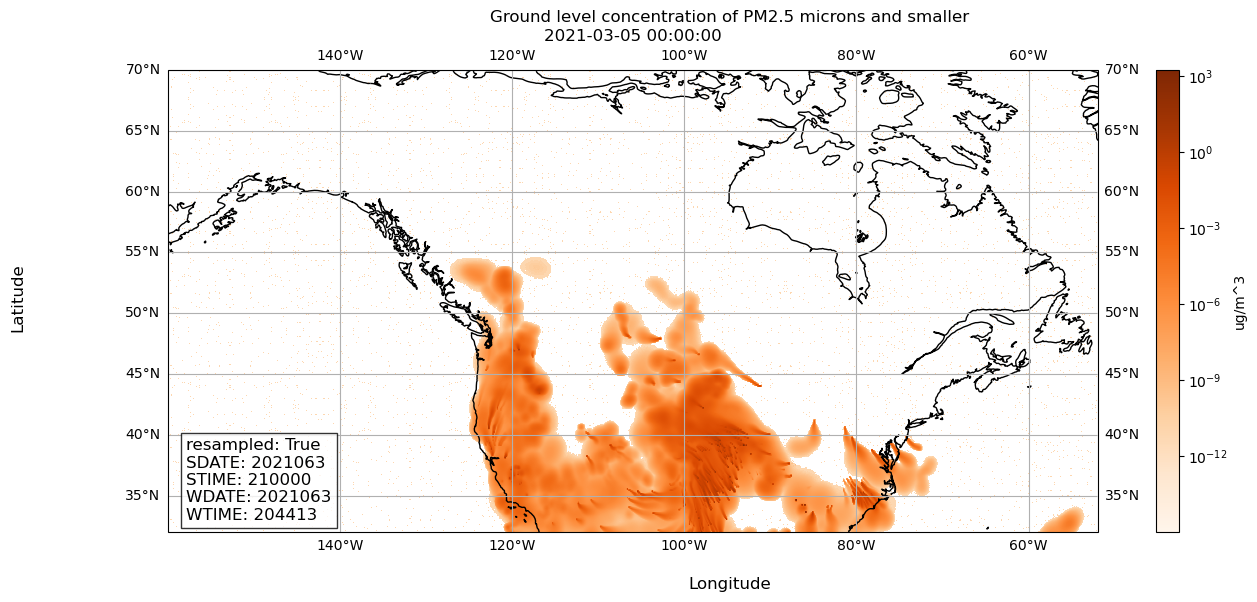

In [13]:
# Let's use matplotlib's imshow, since our data is on a grid
# ref: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html

# Initialize a figure and plot, so we can customize figure and plot of data
# ref: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html
# ref: https://scitools.org.uk/cartopy/docs/latest/getting_started/index.html
my_fig, my_plt = plt.subplots(figsize=(15, 6), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Let's set some parameters to get the visualization we want
# ref: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html

# color PM25 values on a log scale, since values are small
my_norm = "log" 
# this will number our x and y axes based on the longitude latitude range
my_extent = [np.min(longitude), np.max(longitude), np.min(latitude), np.max(latitude)]
# ensure the aspect ratio of our plot fits all data, matplotlib can does this automatically
my_aspect = 'auto'
# tell matplotlib, our origin is the lower-left corner
my_origin = 'lower'
# select a colormap for our plot and the color bar on the right
my_cmap = 'Oranges'

# create our plot using imshow
plot = my_plt.imshow(data_array_at_time.values, norm=my_norm, extent=my_extent, 
          aspect=my_aspect, origin=my_origin, cmap=my_cmap)

# draw coastlines
my_plt.coastlines()

# draw latitude longitude lines
# ref: https://scitools.org.uk/cartopy/docs/latest/gallery/gridlines_and_labels/gridliner.html
my_plt.gridlines(draw_labels=True)

# add a colorbar to our figure, based on the plot we just made above
my_fig.colorbar(plot,location='right', label='ug/m^3')

# Add metadata as text annotations
metadata_text = (
    f'resampled: {resampled.values}\n'
    f'SDATE: {sdate.values}\n'
    f'STIME: {stime.values}\n'
    f'WDATE: {wdate.values}\n'
    f'WTIME: {wtime.values}'
)

# Place metadata text on the plot
my_plt.text(0.02, 0.02, metadata_text, transform=my_plt.transAxes,
            fontsize=12, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.8))

# Set x and y axis labels on our ax
my_fig.supxlabel('Longitude')
my_fig.supylabel('Latitude')

# Set title of our figure
my_fig.suptitle('Ground level concentration of PM2.5 microns and smaller')

# Set title of our plot as the timestamp of our data
my_plt.set_title(f'{my_timestamp}')

# Show the resulting visualization
plt.show()

Here we plot with xarray's built-in matplotlib powered plotter.

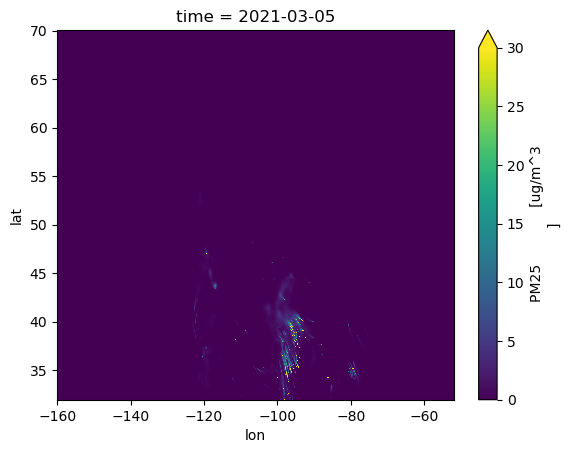

In [14]:
data_array_at_time.plot(vmin=0, vmax=30)

---
Here we plot data_array_at_latlon. We use the exact same code, but define `my_extent` accordingly.

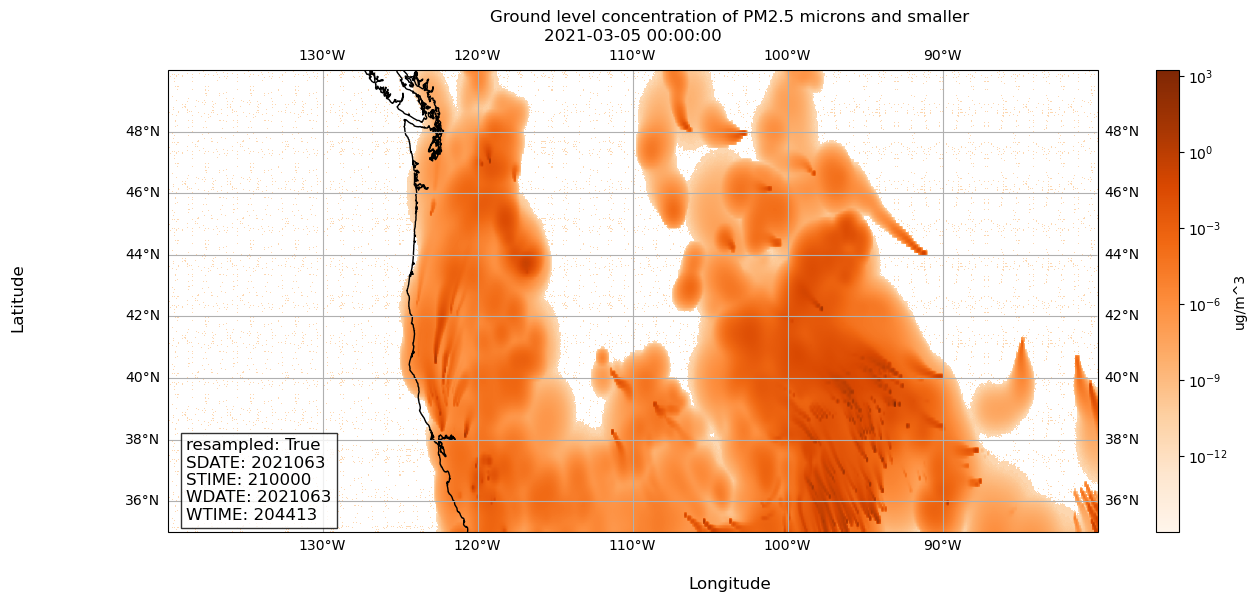

In [15]:
# Let's use matplotlib's imshow, since our data is on a grid
# ref: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html

# Initialize a figure and plot, so we can customize figure and plot of data
# ref: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html
my_fig, my_plt = plt.subplots(figsize=(15, 6), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Let's set some parameters to get the visualization we want
# ref: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html

# color PM25 values on a log scale, since values are small
my_norm = "log" 
# ***this will number our x and y axes based on the longitude latitude range***
my_extent = [min_lon, max_lon, min_lat, max_lat]
# ensure the aspect ratio of our plot fits all data, matplotlib can does this automatically
my_aspect = 'auto'
# tell matplotlib, our origin is the lower-left corner
my_origin = 'lower'
# select a colormap for our plot and the color bar on the right
my_cmap = 'Oranges'

# create our plot using imshow
plot = plt.imshow(data_array_at_latlon.values, norm=my_norm, extent=my_extent, 
          aspect=my_aspect, origin=my_origin, cmap=my_cmap)

# draw coastlines
my_plt.coastlines()

# draw latitude longitude lines
# ref: https://scitools.org.uk/cartopy/docs/latest/gallery/gridlines_and_labels/gridliner.html
my_plt.gridlines(draw_labels=True)

# add a colorbar to our figure, based on the plot we just made above
my_fig.colorbar(plot,location='right', label='ug/m^3')

# Add metadata as text annotations
metadata_text = (
    f'resampled: {resampled.values}\n'
    f'SDATE: {sdate.values}\n'
    f'STIME: {stime.values}\n'
    f'WDATE: {wdate.values}\n'
    f'WTIME: {wtime.values}'
)

# Place metadata text on the plot
my_plt.text(0.02, 0.02, metadata_text, transform=my_plt.transAxes,
            fontsize=12, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.8))

# Set x and y axis labels on our ax
my_fig.supxlabel('Longitude')
my_fig.supylabel('Latitude')

# Set title of our figure
my_fig.suptitle('Ground level concentration of PM2.5 microns and smaller')

# Set title of our plot as the timestamp of our data
my_plt.set_title(f'{my_timestamp}')

# Show the resulting visualization
plt.show()

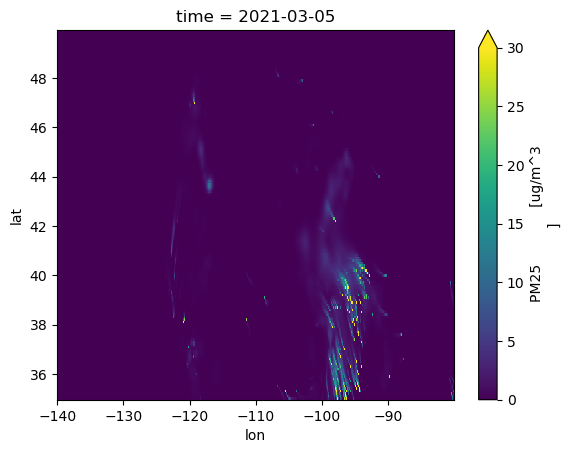

In [16]:
data_array_at_latlon.plot(vmin=0, vmax=30)

### *Please reach out to Arleth Salinas or Valerio Pascucci for any concerns about the notebook. Thank you!*
- Arleth Salinas (arleth.salinas@utah.edu)
- Valerio Pascucci (pascucci.valerio@gmail.com)